**Welcome to TerrainDCGAN!**

This is a Deep  Convolutional Generative Adversarial Network (DCGAN) model designed to generate realistic terrain heightmaps given a dataset of real-life terrain maps.

In [1]:
import torch  # core pytorch library
import torch.nn as nn  # neural network building blocks
from torch.utils.data import DataLoader, Dataset  # data handling utilities
from torchvision import transforms  # image preprocessing and augmentation
from torchvision.utils import save_image  # utility for saving generated images
from PIL import Image  # image file handling
import numpy as np  # numerical operations with arrays
import os  # file and directory handling
from matplotlib.pyplot import imshow, imsave  # functions for displaying and saving images

from google.colab import drive  # colab google drive integration
drive.mount('/content/drive')  # mount google drive to access files

Mounted at /content/drive


In [2]:
MODEL_NAME = 'TerrainDCGAN_COLAB'  # name for the current model run
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use gpu if available, else cpu
WEIGHTS_DIR = "/content/drive/MyDrive/Weights"  # directory path for saved weights
G_WEIGHT_PATH = os.path.join(WEIGHTS_DIR, "G_CNN.pkl")  # file path for generator weights
D_WEIGHT_PATH = os.path.join(WEIGHTS_DIR, "D_CNN.pkl")  # file path for discriminator weights
BATCH_SIZE = 64  # training batch size
IMAGE_SIZE = 128  # size of generated images (pixels per side)
N_NOISE = 100  # dimension of input noise vector for generator
MAX_EPOCH = 50  # maximum number of training epochs
N_CRITIC = 2  # number of discriminator updates per generator update

print(DEVICE)  # print which device is being used

cuda


In [3]:
DATA_PATH = "/content/dataset/Users/mshestopalov/Datasets/processed_dataset_less_water"  # path where dataset will be available after extraction
tar_path = "/content/drive/MyDrive/Datasets/processed_dataset_less_water.tar.gz"  # path to compressed dataset archive in google drive
extract_path = "/content/dataset"  # directory where archive will be extracted
os.makedirs(extract_path, exist_ok=True)  # create extraction directory if it does not exist
!tar -xzf "$tar_path" -C "$extract_path"  # extract tar.gz archive into target directory
os.makedirs(DATA_PATH, exist_ok=True)  # ensure dataset subdirectory exists
# !ls /content/dataset/Users/mshestopalov/Datasets/processed_dataset_less_water  # list extracted dataset contents

In [4]:
def get_one_sample_image(G, n_noise):  # generate a grid of sample images from the generator using random noise
    z = torch.randn(1, n_noise).to(DEVICE)  # sample latent noise vectors of size (1, n_noise) and move to device
    y_hat = G(z).view(1, IMAGE_SIZE, IMAGE_SIZE)  # pass noise through generator to produce fake images, reshape each to (IMAGE_SIZE, IMAGE_SIZE)
    result = y_hat.cpu().data.numpy()  # move generated images to cpu and convert to numpy for processing
    img = np.zeros([IMAGE_SIZE, IMAGE_SIZE])  # create blank canvas to place image in a grid
    for j in range(1):  # 1 row
        img[j*IMAGE_SIZE:(j+1)*IMAGE_SIZE] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img  # return the image

In [5]:
def get_sample_image(G, n_noise):  # generate a grid of sample images from the generator using random noise
    z = torch.randn(100, n_noise).to(DEVICE)  # sample latent noise vectors of size (100, n_noise) and move to device
    y_hat = G(z).view(100, IMAGE_SIZE, IMAGE_SIZE)  # pass noise through generator to produce fake images, reshape each to (IMAGE_SIZE, IMAGE_SIZE)
    result = y_hat.cpu().data.numpy()  # move generated images to cpu and convert to numpy for processing
    img = np.zeros([IMAGE_SIZE*10, IMAGE_SIZE*10])  # create blank canvas to place 100 images in a 10x10 grid
    for j in range(10):  # iterate over rows in the grid
        img[j*IMAGE_SIZE:(j+1)*IMAGE_SIZE] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)  # concatenate 10 images horizontally for each row
    return img  # return the full 10x10 grid image composed of generated samples

In [6]:
class TerrainDataset(Dataset):  # custom dataset class for loading terrain heightmap images

    def __init__(self, root_dir, transform=None):  # initialize with dataset directory and optional transform
        self.root_dir = root_dir  # store dataset root directory
        self.transform = transform  # store optional transform pipeline
        self.img_files = [f for f in os.listdir(root_dir) if f.endswith("_h.png")]  # collect all image filenames ending with "_h.png"

    def __len__(self):  # return number of samples in dataset
        return len(self.img_files)

    def __getitem__(self, idx):  # load a single sample by index
        img_path = os.path.join(self.root_dir, self.img_files[idx])  # build full path for selected image
        image = Image.open(img_path).convert("L")  # open image and convert to grayscale
        if self.transform:  # apply transform pipeline if provided
            image = self.transform(image)
        return image  # return the processed image tensor

In [7]:
class Discriminator(nn.Module):  # cnn-based discriminator class
    def __init__(self, image_size=IMAGE_SIZE):
        super(Discriminator, self).__init__()
        self.image_size = image_size  # store image size for reshaping input. since we take in a flat vector, we need to reshape it to a tensor to apply a convolution

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # first conv layer, downsample image by half
            nn.LeakyReLU(0.2, inplace=True),  # leaky relu activation

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # second conv layer, downsample again
            nn.BatchNorm2d(128),  # normalize activations to stabilize training
            nn.LeakyReLU(0.2, inplace=True),  # non-linearity

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # third conv layer
            nn.BatchNorm2d(256),  # batch norm
            nn.LeakyReLU(0.2, inplace=True),  # activation

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # fourth conv layer, final downsample
            nn.BatchNorm2d(512),  # batch norm
            nn.LeakyReLU(0.2, inplace=True),  # activation

            nn.Flatten(),  # flatten feature maps into a vector
            nn.Linear((image_size // 16) * (image_size // 16) * 512, 1),  # dense layer to scalar output
            nn.Sigmoid()  # sigmoid for probability between 0 and 1
        )

    def forward(self, x):  # forward pass of discriminator
        x = x.view(x.size(0), 1, self.image_size, self.image_size)  # reshape input to 4d tensor (batch, 1, h, w)
        return self.model(x)  # run through cnn


class Generator(nn.Module):  # cnn-based generator class
    def __init__(self, latent_dim=100, image_size=IMAGE_SIZE):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim  # size of noise vector
        self.image_size = image_size  # size of output image

        self.init_size = image_size // 16  # starting spatial size after fully connected expansion
        self.fc = nn.Linear(latent_dim, 512 * self.init_size * self.init_size)  # project noise into feature map. since we take in a flat vector, we need to reshape it to a tensor to apply a convolution

        self.model = nn.Sequential(
            nn.BatchNorm1d(512 * self.init_size * self.init_size),  # normalize projection

            nn.Unflatten(1, (512, self.init_size, self.init_size)),  # reshape into (batch, channels, h, w)

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # upsample to double spatial size
            nn.BatchNorm2d(256),  # batch norm
            nn.ReLU(True),  # relu activation

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # upsample again
            nn.BatchNorm2d(128),  # batch norm
            nn.ReLU(True),  # activation

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # upsample again
            nn.BatchNorm2d(64),  # batch norm
            nn.ReLU(True),  # activation

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # final layer, outputs 1-channel image
            nn.Tanh()  # output in range [-1, 1]
        )

    def forward(self, z):  # forward pass of generator
        out = self.fc(z)  # project noise to initial feature map
        out = self.model(out)  # run through upsampling network
        return out.view(out.size(0), 1, self.image_size, self.image_size)  # return generated image tensor

In [8]:
transform = transforms.Compose([  # define preprocessing pipeline
    transforms.ToTensor(),  # convert image to tensor with values in [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1] for stable GAN training
])

dataset = TerrainDataset(root_dir=DATA_PATH, transform=transform)  # load custom terrain dataset with transforms
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)  # create dataloader for batching and shuffling

In [9]:
D = Discriminator().to(DEVICE)  # initialize discriminator and move to device
G = Generator(N_NOISE).to(DEVICE)  # initialize generator with latent noise dimension and move to device

try:  # try loading pretrained weights if available
  if os.path.exists(D_WEIGHT_PATH) and os.path.exists(G_WEIGHT_PATH):  # check cnn weight paths
      D.load_state_dict(torch.load(D_WEIGHT_PATH, map_location=DEVICE))  # load discriminator weights
      G.load_state_dict(torch.load(G_WEIGHT_PATH, map_location=DEVICE))  # load generator weights
      print("Loaded pretrained weights from Google Drive.")
  if os.path.exists(os.path.join(WEIGHTS_DIR, "D.pkl")) and os.path.exists(os.path.join(WEIGHTS_DIR, "G.pkl")):  # check other weight paths
      D.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR, "D.pkl"), map_location=DEVICE))  # load discriminator weights
      G.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR, "G.pkl"), map_location=DEVICE))  # load generator weights
      print("Loaded pretrained weights from Google Drive.")
  else:  # no pretrained weights found
      print("No pretrained weights found, starting from scratch.")
except:  # catches errors like changed model architecture
  print("No pretrained weights found, starting from scratch.")

criterion = nn.BCELoss()  # binary cross entropy loss for real vs fake classification
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))  # adam optimizer for discriminator
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))  # adam optimizer for generator

real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)  # label tensor of 1s for real images
fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)  # label tensor of 0s for fake images

os.makedirs('samples', exist_ok=True)  # make directory to save generated samples

Loaded pretrained weights from Google Drive.
Loaded pretrained weights from Google Drive.


In [10]:
step = 0  # global step counter
for epoch in range(MAX_EPOCH):  # loop over all epochs
    for images in dataloader:  # loop over batches from dataloader
        images = images.to(DEVICE)  # move batch to device

        # --- train discriminator ---
        D_real = D(images)  # forward pass real images through discriminator
        D_real_loss = criterion(D_real, real_labels)  # compute loss for real images

        z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)  # sample latent noise
        D_fake = D(G(z))  # forward pass generated images through discriminator
        D_fake_loss = criterion(D_fake, fake_labels)  # compute loss for fake images

        D_loss = D_real_loss + D_fake_loss  # total discriminator loss
        D.zero_grad()  # zero gradients before backward pass
        D_loss.backward()  # backpropagate discriminator loss
        D_opt.step()  # update discriminator weights

        # --- train generator ---
        if step % N_CRITIC == 0:  # update generator every n_critic steps
            z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)  # sample new latent noise
            G_fake = D(G(z))  # forward pass generated images through discriminator
            G_loss = criterion(G_fake, real_labels)  # generator tries to fool discriminator

            G.zero_grad()  # zero gradients for generator
            G_loss.backward()  # backpropagate generator loss
            G_opt.step()  # update generator weights

        # logging losses every 500 steps
        if step % 500 == 0:
            print(f"Epoch [{epoch}/{MAX_EPOCH}], Step {step}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")  # print current losses

        # save sample images every 1000 steps
        if step % 1000 == 0:
            G.eval()  # switch generator to evaluation mode
            img = get_sample_image(G, N_NOISE)  # generate sample image grid from latent noise
            imsave(f'samples/{MODEL_NAME}_step{step:03d}.jpg', img, cmap='gray')  # save image
            G.train()  # switch back to training mode

        step += 1  # increment global step

    # save model weights at the end of each epoch. this means we can stop the notebook even if we haven't run all the epochs yet
    torch.save(D.state_dict(), D_WEIGHT_PATH)  # save discriminator weights
    torch.save(G.state_dict(), G_WEIGHT_PATH)  # save generator weights
    print(f"Epoch {epoch} completed. Weights saved to Google Drive.")  # log checkpoint

Epoch [0/50], Step 0, D Loss: 0.0144, G Loss: 4.0442


KeyboardInterrupt: 

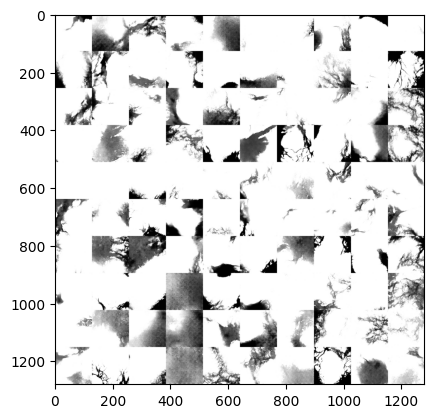

In [14]:
G.eval()  # switch generator to evaluation mode
imshow(get_sample_image(G, N_NOISE), cmap='gray')  # show an example image (100 terrain maps)

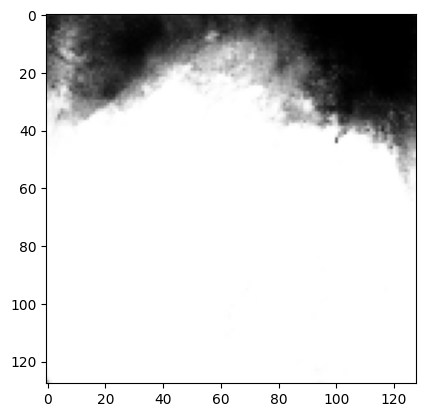

In [29]:
imshow(get_one_sample_image(G, N_NOISE), cmap='gray')  # show an example image (1 terrain map)